In [1]:
import numpy as np
import pandas as pd

In [102]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import joblib
import pickle
from datetime import datetime
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, accuracy_score, precision_score, recall_score, f1_score, classification_report,  confusion_matrix

In [3]:
dfFinal = pd.read_csv(r'gs://cloud-ai-platform-9a0d9aeb-97fd-41ed-9a1a-8ee8a5e205bc/differenceAllLevels.csv').sample(5_000_00, random_state=42)

In [4]:
xcols = ['inlandDistance', 'elevation', 'waterDistance', 'waterLevel', 'bathtubDepth']
ycols = ['difference']
indices = dfFinal.index
x = dfFinal[xcols]
y = dfFinal[ycols]

In [5]:
xcols = ['inlandDistance', 'elevation', 'waterDistance', 'waterLevel', 'bathtubDepth']
ycols = ['difference']
indices = dfFinal.index
x = dfFinal[xcols]
y = dfFinal[ycols]

In [6]:
X = x.to_numpy()
y = y.to_numpy()

In [7]:
XX_train, XX_test, yy_train, yy_test = train_test_split(X, y, test_size=0.2, random_state=42)
XX_test, XX_val, yy_test, yy_val = train_test_split(XX_test, yy_test, test_size=0.5, random_state=42) 

In [8]:
# Binning continous target values into 100 bins and encoding into one-hot vectors for multiclass classification 
est = KBinsDiscretizer(n_bins=100, encode='ordinal', strategy='uniform')
labels = est.fit(y.reshape(-1,1))
labels = est.transform(y.reshape(-1,1))

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42) 

In [55]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val =  scaler.fit_transform(X_val)

In [56]:
y_train = y_train.ravel()
y_val = y_val.ravel()
y_test = y_test.ravel()

In [12]:
best_estimators = {'max_depth':20, 'n_estimators':300}

In [13]:
rfc = RandomForestClassifier(random_state = 42, max_depth = 20, n_estimators=300, verbose = 1)

In [14]:
# Fir Random Forest Classifier
print(datetime.now())
rfc.fit(X_train, y_train)
print(datetime.now())

2022-12-04 04:17:19.085581


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2022-12-04 04:25:16.519583


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  8.0min finished


In [58]:
# Validation set prediction
y_pred_val = rfc.predict(X_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   21.9s finished


In [16]:
# Training set prediction
y_pred_train = rfc.predict(X_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.4min finished


In [17]:
# Validation set accuracy
accuracy_score(y_pred_val, y_val)

0.7618

In [18]:
# Training set accuracy
accuracy_score(y_pred_train, y_train)

0.9309075

In [20]:
# Transform y_val to continuous values
y_val = est.inverse_transform(yy_val)

In [43]:
# Dictionary mapping class value to the mean bin value
classes = {'bin':np.arange(-10.2485, 10.8835, 0.213), 'class':np.arange(100.0)}
classes = {classes['class'][i] : classes['bin'][i] for i in range(len(classes['class']))}

In [72]:
# Convert validation predictions to continous values
y_val_conv = est.inverse_transform(y_val.reshape(-1,1))

In [67]:
# Convert validation predictions to continous values
y_pred_val_conv = np.zeros(len(y_val))
for i in range(len(y_val)):
    y_pred_val_conv[i] = classes[y_pred_val[i]]

In [73]:
y_val_conv

array([[-3.19722602e+00],
       [ 8.56307700e-01],
       [ 2.93218000e-03],
       ...,
       [ 8.56307700e-01],
       [ 2.93218000e-03],
       [ 2.16276060e-01]])

In [69]:
y_pred_val_conv

array([-4.7105,  0.8275, -0.0245, ...,  0.8275, -0.0245,  0.1885])

In [76]:
r2_score(y_val_conv, y_pred_val_conv)

0.9177404521968447

In [79]:
mean_squared_error(y_val_conv, y_pred_val_conv)

0.2913837886996714

In [80]:
mean_absolute_error(y_val_conv, y_pred_val_conv)

0.18660013848003018

In [81]:
mean_absolute_percentage_error(y_val_conv, y_pred_val_conv)

7.198196889850471

In [83]:
with open('class2continous.pickle', 'wb') as handle:
    pickle.dump(classes, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [93]:
confusion_matrix = confusion_matrix(y_val, y_pred_val)

In [100]:
confusion_matrix.max()

24017

In [126]:
clf_report = pd.DataFrame(classification_report(y_val, y_pred_val, output_dict = True)).transpose()

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

<AxesSubplot:>

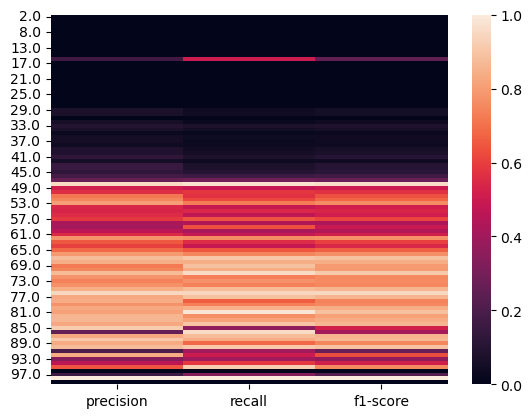

In [144]:
# Calssification Report
clf_report_np = clf_report.iloc[:-3,:-1]
sns.heatmap(clf_report_np)

Text(0.5, 1.0, 'Predicted Differences')

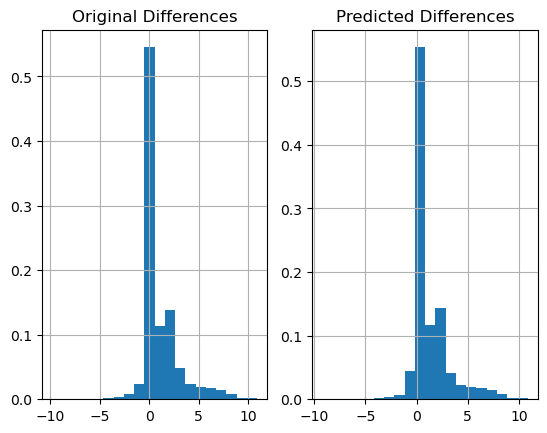

In [137]:
plt.subplot(121)
plt.grid()
plt.hist(y_val_conv, bins = 20, density = True)
plt.title('Original Differences')
plt.subplot(122)
plt.grid()
plt.hist(y_pred_val_conv, bins = 20, density = True)
plt.title('Predicted Differences')

In [ ]:
plt.plot